# **Configuración inicial**

In [1]:
import pandas as pd
import numpy as np
from stargazer.stargazer import Stargazer
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
import scipy as sc
import statsmodels as stats
import arch 
import matplotlib.pyplot as plt
import os 
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

stg = importr('stargazer')

if os.getcwd().split('\\')[len(os.getcwd().split('\\'))-1] != "202510-Series-Taller2":
    os.chdir("..")
print(os.getcwd())

c:\Users\NicolasLozano\OneDrive - Universidad de los andes\UNIVERSIDAD\9. NOVENO SEMESTRE\SERIES DE TIEMPO\TALLERES\202510-Series-Taller2


## **2.a. Cargue de datos, transformación y grafico de la serie**

In [2]:
data_trm = pd.read_excel("data\\TRM.xlsx")

data_trm = data_trm.rename(columns={'Fecha (dd/mm/aaaa)':'date','Tasa de cambio representativa del mercado (TRM)':'trm'})

# Cobnnvertimos la columna fecha a datetime.
data_trm['date'] = pd.to_datetime(data_trm['date'], format='%Y/%m/%d')\

# Especificamos que la columna date debe tomarse como index.
data_trm.set_index('date', inplace=True)

# Se especifica que la frecuencia es diaria.
data_trm = data_trm.asfreq('D')

data_trm = data_trm.resample("M").mean()

print(data_trm)

                    trm
date                   
1991-12-31   630.412581
1992-01-31   644.058065
1992-02-29   635.671724
1992-03-31   640.501935
1992-04-30   649.955000
...                 ...
2024-11-30  4408.652333
2024-12-31  4385.148710
2025-01-31  4307.567419
2025-02-28  4127.953929
2025-03-31  4131.974400

[400 rows x 1 columns]


C:\Users\NicolasLozano\AppData\Local\Temp\ipykernel_27320\2011505052.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_trm = data_trm.resample("M").mean()


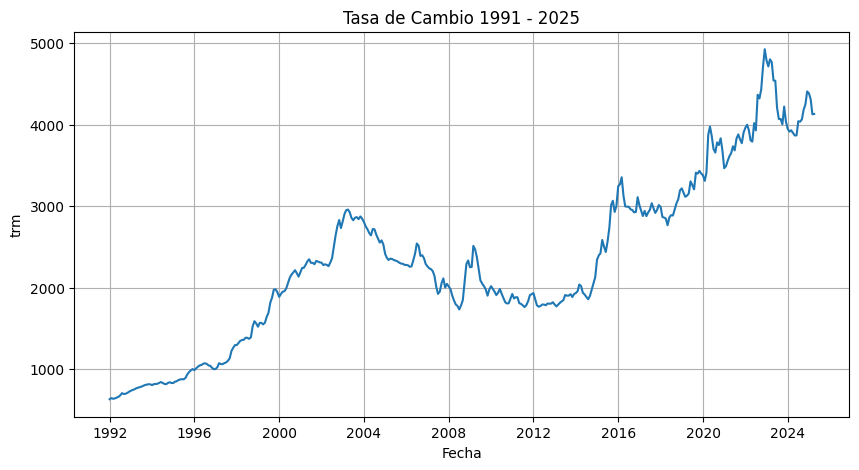

In [3]:
os.makedirs(".\\output", exist_ok=True)

plt.figure(figsize=(10, 5))
plt.plot(data_trm.index,data_trm['trm'],linestyle='-')
plt.xlabel('Fecha')
plt.ylabel('trm')
plt.title('Tasa de Cambio 1991 - 2025')
plt.grid(True)
plt.savefig("output\\graf_trm.png", dpi=300, bbox_inches='tight')
plt.show()

## **2.b. Retorno de la trm**

In [5]:
data_trm['retorno']=(np.log(data_trm['trm'])-np.log(data_trm['trm'].shift(1)))*100

ret_promedio = pd.DataFrame({"Estad\\'istico": ["Retorno Promedio"], "Valor": [data_trm['retorno'].mean()]})

latex_table = ret_promedio.to_latex(index=False, label="tab:retorno_promedio", na_rep='0',multicolumn=True,position='H')
latex_table = latex_table.replace("\\begin{tabular}", "\\centering\n\\begin{tabular}")
latex_table = latex_table.replace("\\end{tabular}", f"\\end{{tabular}}\n\\caption{{Retorno Promedio}}")

with open("output\\retorno_promedio.tex", "w") as f:
     f.write(latex_table)



## **2.c. Retornos sin media al cuadrado**

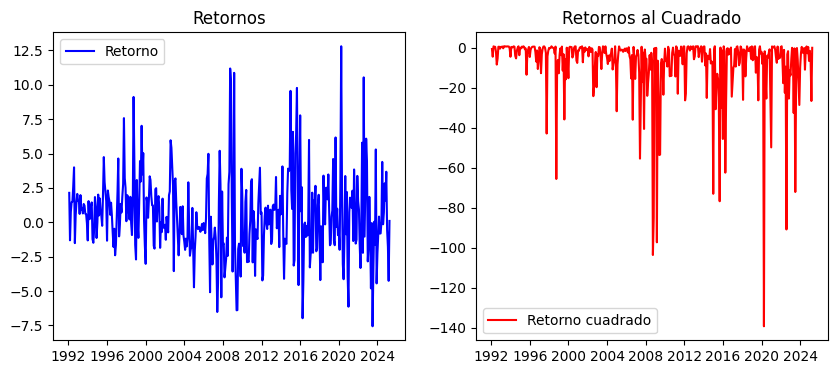

In [6]:
data_trm['retorno2']=data_trm['retorno']-np.square(data_trm['retorno']-data_trm['retorno'].mean())
data_trm['retorno_sin_media']=data_trm['retorno']-data_trm['retorno'].mean()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(data_trm.index,data_trm['retorno'],linestyle='-', label="Retorno", color="b")
ax[0].set_title("Retornos")
ax[0].legend()

ax[1].plot(data_trm.index,data_trm['retorno2'],linestyle='-', label="Retorno cuadrado", color="r")
ax[1].set_title("Retornos al Cuadrado")
ax[1].legend()
plt.savefig("output\\subplot_retornos.png", dpi=300, bbox_inches='tight')
plt.show()


## **2.d. ARIMA**

Revisamos si la serie es estacionaria

In [7]:
test_result = adfuller(data_trm["retorno"].dropna())
print(test_result[0])
print(test_result[1])

-12.740812260255497
8.9533528858756e-24


Como el p-valor es prácticamente 0, rechazamos la hipotesis nula y conluimos que no hay evidencia estadistica de que la serie tenga raíz unitaria. <br>
Puede consultar la documentación de la función adfuller [aqui](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html). <br>
Ahora miramos las autocorrelaciones para estimar los parámetros p y q.

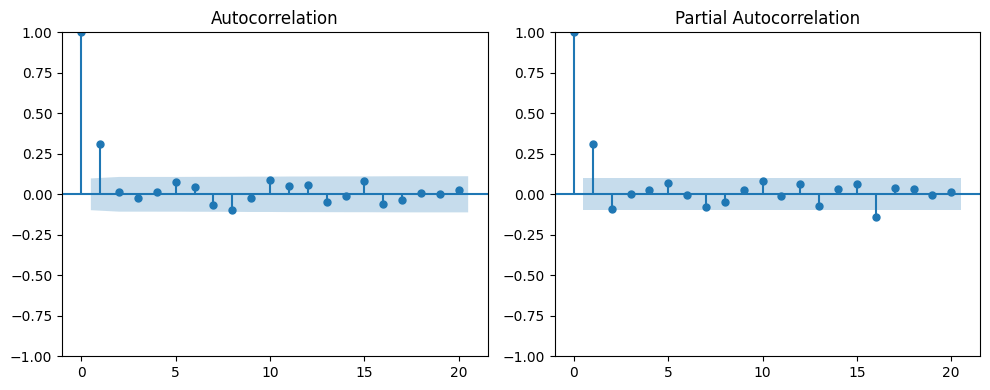

In [8]:
data_trm2 = data_trm.dropna()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_acf(data_trm2['retorno'], ax = axes[0], alpha=0.05, lags=20)
plot_pacf(data_trm2['retorno'], ax = axes[1], alpha=0.05, lags=20)

plt.tight_layout()
plt.show()

Vemos que las autocorrelaciones y las autocorrelaciones parciales rapidamente entran en los intervalos de confianza lo que refuerza la hipótesis de que la serie es estacionaria.

Realizamos un autoarima

In [9]:
ar=4
ma=4

matrix_aic = np.full((ar+1, ma+1), np.nan)
matrix_bic = np.full((ar+1, ma+1),np.nan)

for i in range(ar+1):
    for j in range(ma+1):
        model = ARIMA(data_trm2['retorno'], order=(i, 0, j))
        model_fit = model.fit()

        aic=model_fit.aic
        bic=model_fit.bic

        matrix_aic[i,j] =aic
        matrix_bic[i,j] = bic

min_aic=np.min(matrix_aic)
min_bic=np.min(matrix_bic)

aic_ar_min, aic_ma_min = np.unravel_index(np.argmin(matrix_aic), matrix_aic.shape) 

bic_ar_min, bic_ma_min = np.unravel_index(np.argmin(matrix_bic), matrix_bic.shape) 

print(f"{aic_ar_min}   {aic_ma_min}")

print(f"{bic_ar_min}   {bic_ma_min}")


c:\Users\NicolasLozano\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\NicolasLozano\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\NicolasLozano\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\NicolasLozano\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertibl

2   3
0   1


c:\Users\NicolasLozano\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
